# Language Modeling with Recurrent Neural Networks

In this notebook, we will see how you can train a recurrent neural network language model.

We will start by importing TensorFlow, which is Google's open-source library for machine learning. Next, we will explain how to do data processing for language modeling and explain the most important classes and function that we will use. We will give a short introduction to word embeddings, testing a network and the importance of hyperparameters during training.

Dependencies:
- Tensorflow: This notebook uses TensorFlow.compat.v1.  This does generate a number of deprecation WARNINGS. This is normal and no action is required.

## Importing TensorFlow and other requirements

We start by importing TensorFlow and checking if we are running on GPU. You will probably be asked two confirmations; click YES twice. 

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

Instructions for updating:
non-resource variables are not supported in the long term


If the code above raised an error, you should make sure that you are using a GPU in the following way: select 'Runtime' in the top bar, then 'Change runtime type' and choose 'GPU' as hardware accelerator. Training neural networks is much faster on a GPU (graphics processing unit) than on a CPU.

Next, we import the other standard Python packages that we need. 

In [2]:
import numpy as np
import urllib, collections, os
from __future__ import print_function

In the 3 cells below we are defining some classes and functions that we will use throughout the notebook. You have to run the cells to make sure you can use them, but you do not have to look at the details in the code. By default we have hidden this code, but you may click on SHOW CODE to visualize each of them (batchGenerator.py, rnn_lm.py and run_lm.py).

In [3]:
#@title
class batchGenerator(object):
  '''
  This class generates batches for a dataset.
  Input arguments:
    data: list of indices (word ids)
    batch_size: number of sequences in a mini-batch
    num_steps: length of each sequence in the mini-batch
    test: boolean, is True if we are testing; in that case batch_size and num_steps are 1
  '''
  
  def __init__(self, data, batch_size=32, num_steps=50, test=False):
    '''
    Prepares a dataset.
    '''
    self.batch_size = batch_size
    self.num_steps = num_steps
    self.test = test 

    self.data_array = np.array(data)
  
    if not self.test:
      len_batch_instance = int(len(data) / batch_size)

      print(int(batch_size*len_batch_instance))
      data_array = self.data_array[:batch_size*len_batch_instance]

      # divide data in batch_size parts
      self.data_reshaped = np.reshape(data_array, (batch_size, len_batch_instance))

      # number of mini-batches that can be generated
      self.num_batches_in_data = len_batch_instance / num_steps - 1
    
    self.curr_idx = 0
  
  def generate(self):
    '''
    Generates
      input_batch: numpy array (batch_size x num_steps) or None, if the end of the dataset is reached
      target_batch: numpy array (batch_size x num_steps) or None, if the end of the dataset is reached
      end_reached: boolean, True is end of dataset is reached
    '''
    
    if self.test:
      if self.curr_idx+1 >= len(self.data_array):
        return None, None, True
      
      input_batch = [[self.data_array[self.curr_idx]]]
      target_batch = [[self.data_array[self.curr_idx+1]]]
      
    else:
      if self.curr_idx >= self.num_batches_in_data:
        return None, None, True

      # input: take slice of size 
      input_batch = self.data_reshaped[:,self.curr_idx*self.num_steps:self.curr_idx*self.num_steps+self.num_steps]

      # target = input shifted 1 time step
      target_batch = self.data_reshaped[:,self.curr_idx*self.num_steps+1:self.curr_idx*self.num_steps+self.num_steps+1]

    self.curr_idx += 1
    
    return input_batch, target_batch, False


In [4]:
#@title
class rnn_lm(object):
  '''
  This is a class to build and execute a recurrent neural network language model.
  Arguments:
    cell: type of RNN cell (only LSTM is currently implemented)
    optimizer: 'SGD' or 'Adam'
    lr: learning rate
    vocab_size: size of the vocabulary
    embedding_size: size of continuous embedding that will be input to the RNN
    hidden_size: size of the hidden layer
    dropout rate: value between 0 and 1, number of neurons that will be 
        kept (not dropped) during training, prevents overfitting
    batch_size: number of sequences that will be input simultaneously
    num_steps: length of each input sequence = number of steps in backpropagation through time
    is_training: boolean, True is we want to update the parameters of the model
  '''
  
  def __init__(self,
              cell='LSTM',
              optimizer='Adam',
              lr=0.01,
              vocab_size=10000,
              embedding_size=64,
              hidden_size=128,
              dropout_rate=0.5,
              batch_size=32,
              num_steps = 50,
              is_training=True):
    # hyperparameters that can be changed
    self.which_cell = cell
    self.which_optimizer = optimizer
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.dropout_rate = dropout_rate
    self.is_training = is_training
    self.lr = lr
    self.batch_size = batch_size
    self.num_steps = num_steps
    
    # hard-coded hyperparameters
    self.max_grad_norm = 5
    
    self.init_graph()
    
    self.output, self.state = self.feed_to_network()
    
    self.loss = self.calc_loss(self.output)
    
    if self.is_training:
      self.update_params(self.loss)
    
    
  def init_graph(self):
    '''
    This function initializes all elements of the network.
    '''
    
    self.inputs = tf.placeholder(dtype=tf.int32, shape=[self.batch_size, self.num_steps])
    self.targets = tf.placeholder(dtype=tf.int32, shape=[self.batch_size, self.num_steps])
    
    # input embedding weights
    self.embedding = tf.get_variable("embedding", 
                                     [self.vocab_size, self.embedding_size], 
                                     dtype=tf.float32)
    
    # hidden layer
    if self.which_cell == 'LSTM':
      self.basic_cell = tf.nn.rnn_cell.LSTMCell(self.hidden_size)
    elif self.which_cell == 'RNN':
      self.basic_cell = tf.nn.rnn_cell.BasicRNNCell(self.hidden_size)
    else:
      raise ValueError("Specify which type of RNN you want to use: RNN or LSTM.")
      
    # apply dropout  
    self.cell = tf.nn.rnn_cell.DropoutWrapper(self.basic_cell, 
                                              output_keep_prob=self.dropout_rate)
    
    # initial state contains all zeros
    self.initial_state = self.cell.zero_state(self.batch_size, tf.float32)
    
    # output weight matrix and bias
    self.softmax_w = tf.get_variable("softmax_w",
                                     [self.hidden_size, self.vocab_size], 
                                     dtype=tf.float32)
    self.softmax_b = tf.get_variable("softmax_b",
                                     [self.vocab_size], 
                                     dtype=tf.float32)
    
    self.initial_state = self.cell.zero_state(self.batch_size, dtype=tf.float32)
    
    
  def feed_to_network(self):
    '''
    This function feeds the input to the network and returns the output and the state.
   
    '''
    
    # map input indices to continuous input vectors
    inputs = tf.nn.embedding_lookup(self.embedding, self.inputs)

	  # use dropout on the input embeddings
    inputs = tf.nn.dropout(inputs, self.dropout_rate)
    
    state = self.initial_state
    
    # feed inputs to network: outputs = predictions, state = new hidden state
    outputs, state = tf.nn.dynamic_rnn(self.cell, inputs, sequence_length=None, initial_state=state)
    
    output = tf.reshape(tf.concat(outputs, 1), [-1, self.hidden_size])
    
    return output, state
    
  
  def calc_loss(self, output):
    
    # calculate logits
    # shape of logits = [batch_size*num_steps, vocab_size]
    logits = tf.matmul(output, self.softmax_w) + self.softmax_b
    
    self.softmax = tf.nn.softmax(logits)
      
    # calculate cross entropy loss
    # reshape targets such that it has shape [batch_size*num_steps]
    # loss: contains loss for every time step in every batch
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=tf.reshape(self.targets, [-1]), logits=logits)
      
    # average loss per batch
    avg_loss = tf.reduce_sum(loss) / self.batch_size
    
    return avg_loss
  
  def update_params(self, loss):
    
    # calculate gradients for all trainable variables 
    # + clip them if their global norm > 5 (prevents exploding gradients)
    grads, _ = tf.clip_by_global_norm(
        tf.gradients(loss, tf.trainable_variables()), self.max_grad_norm)
    
    if self.which_optimizer == 'SGD':
      optimizer = tf.train.GradientDescentOptimizer(self.lr)
    elif self.which_optimizer == 'Adam':
      optimizer = tf.train.AdamOptimizer(self.lr)
    else:
      raise ValueError("Specify which type of optimizer you want to use: SGD or Adam.")
    
    # update the weights
    self.train_op = optimizer.apply_gradients(
				zip(grads, tf.trainable_variables()))

In [5]:
#@title
def run_lm(name='LSTM', cell='LSTM', 
           optimizer='Adam', lr=0.01, 
           vocab_size = 10000, embedding_size=64, 
           hidden_size=128, dropout_rate=0.5, 
           num_steps=50, inspect_emb=False, 
           train_ids=None, valid_ids=None, 
           test_ids=None, test_log_prob=False):
  '''
  Creates training, validation and/or test models,
  trains, validates and/or tests the model.
  Arguments:
    name: name that will be used to save the model
    cell: type of RNN cell (only LSTM is currently implemented)
    optimizer: 'SGD' or 'Adam'
    lr: learning rate
    vocab_size: size of the vocabulary
    embedding_size: size of continuous embedding that will be input to the RNN
    hidden_size: size of the hidden layer
    dropout rate: value between 0 and 1, number of neurons that will be 
        kept (not dropped) during training, prevents overfitting
    num_steps
    inspect_emb: boolean, if True we want to return the embedding_matrix
    train_ids: training data
    valid_ids: validation data
    test_ids: test data
    test_log_prob: boolean, if True we only want to test the log probability for a test sentence
  '''
    
  with tf.Graph().as_default() as graph:

      # create the models
      if not test_log_prob:
      
        with tf.variable_scope("Model"):
          rnn_train = rnn_lm(cell=cell,
                             optimizer=optimizer, 
                             lr=lr,
                             vocab_size=vocab_size,
                             embedding_size=embedding_size,
                             hidden_size=hidden_size,
                             dropout_rate=dropout_rate)

          saver = tf.train.Saver()

        with tf.variable_scope("Model", reuse=True):
          rnn_valid = rnn_lm(cell=cell, 
                             optimizer=optimizer,
                             lr=lr,
                             vocab_size=vocab_size, 
                             embedding_size=embedding_size,
                             hidden_size=hidden_size,
                             dropout_rate=dropout_rate,
                             is_training=False)
          
        reuse = True
        
      else:
        reuse = False
               
      with tf.variable_scope("Model", reuse=reuse):
        rnn_test = rnn_lm(cell=cell, 
                           optimizer=optimizer, 
                           lr=lr,
                           vocab_size=vocab_size,
                           embedding_size=embedding_size,
                           hidden_size=hidden_size,
                           dropout_rate=dropout_rate,
                           batch_size=1,
                           num_steps=1,
                           is_training=False)
      

      sv = tf.train.Supervisor(logdir=name)

      with sv.managed_session(config=tf.ConfigProto()) as session:
        
        if not test_log_prob:
        
          for i in range(5):

            print('Epoch {0}'.format(i+1))

            train_ppl = run_epoch(session, rnn_train, train_ids, num_steps=num_steps)
            print('Train perplexity: {0}'.format(train_ppl))

            valid_ppl = run_epoch(session, rnn_valid, valid_ids, num_steps=num_steps, is_training=False)
            print('Validation perplexity: {0}'.format(valid_ppl))

          save_path = saver.save(session, "{0}/rnn.ckpt".format(name))
          print('Saved the model to ',save_path)

        test_ppl = run_epoch(session, rnn_test, test_ids, num_steps=num_steps,
                             is_training=False, is_test=True, 
                             test_log_prob=test_log_prob)
        if not test_log_prob:
          print('Test perplexity: {0}'.format(test_ppl))
        
        if inspect_emb: 
          emb_matrix = tf.get_default_graph().get_tensor_by_name("Model/embedding:0")
          emb_matrix_np = emb_matrix.eval(session=session)

          return emb_matrix_np

        else:

          return None

def run_epoch(session, rnn, data, num_steps=50, is_training=True, is_test=False, test_log_prob=False):
    '''
    This function runs a single epoch (pass) over the data,
    updating the model parameters if we are training,
    and returns the perplexity.
    Input arguments:
      rnn: object of the rnn_lm class
      data: list of word indices
      num_steps
      is_training: boolean, True is we are training the model
      is_test: boolean, True is we are testing a trained model
      test_log_prob: boolean, True if we want the log probability
    Returns:
      ppl: float, perplexity of the dataset
    '''
  
    generator = batchGenerator(data, test=is_test)
      
    state = session.run(rnn.initial_state)
    sum_loss = 0.0
    iters = 0
    
    if test_log_prob: 
      sum_log_prob = 0.0
      
    while True:

      input_batch, target_batch, end_reached = generator.generate()
        
      if end_reached:
        break

      feed_dict = {rnn.inputs: input_batch,
                  rnn.targets: target_batch,
                  rnn.initial_state : state}

      fetches = {'loss': rnn.loss,
                'state': rnn.state}
      
      if is_training:
        fetches['train_op'] = rnn.train_op
        
      if test_log_prob:
        fetches['softmax'] = rnn.softmax
        
      result = session.run(fetches, feed_dict)
        
      state = result['state']
      loss = result['loss']
      
      if test_log_prob:
        softmax = result['softmax']
        prob_target = softmax[0][target_batch[0][0]]
        sum_log_prob += np.log(prob_target)

      sum_loss += loss
      # the loss is an average over num_steps
      if is_test:
        iters += 1
      else:
        iters += num_steps
        
    # calculate perplexity    
    ppl = np.exp(sum_loss / iters)
    
    if test_log_prob:
      print('Log probability: {0}'.format(sum_log_prob))
    
    return ppl


If you have run all cells in this section, you can now start the following section on data processing.

## Data processing

We will train our language models on **Penn TreeBank**, which is a publicly available benchmark dataset. A benchmark dataset can be used to easily compare models, since everyone has access to the same data. Many published papers use Penn TreeBank as dataset.

Penn TreeBank consists of among others newspaper articles, transcribed telephone conversations and manuals. The training set contains ca. 900.000 words, the validation set ca. 70.000 words and the test set ca. 80.000 words. This is a very small dataset (nowadays language models can be trained on billions of words), but it is large enough for our purposes.

We now download the training, validation and test data:

In [6]:
train_url = 'http://homes.esat.kuleuven.be/~spchlab/data/penntreebank/train.txt'
valid_url = 'http://homes.esat.kuleuven.be/~spchlab/data/penntreebank/valid.txt'
test_url = 'http://homes.esat.kuleuven.be/~spchlab/data/penntreebank/test.txt'
train_file = urllib.request.urlopen(train_url).read()
valid_file = urllib.request.urlopen(valid_url).read()
test_file = urllib.request.urlopen(test_url).read()

The data looks like this:

In [7]:
print('{0}...'.format(valid_file[:500]))

b" consumers may want to move their telephones a little closer to the tv set \n <unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among four or five <unk> <unk> \n two weeks ago viewers of several nbc <unk> consumer segments started calling a N number for advice on various <unk> issues \n and the new syndicated reality show hard copy records viewers ' opinions for possible airing on the next day 's show \n interactive telephone technology"...


The data has been **normalized**: all words not in the vocabulary are mapped to an unknown words class (<unk\>), all numbers are mapped to the 'N' class, each line contains a single sentence, punctuation has been removed, and so on. 

The purpose of normalization is among others to get rid of all information that is not necessary (such as punctuation), to solve redundancies (for example the same word can occur with different spellings, e.g. 'normalisation' or 'normalization', and we want to get rid of such variants) and to make sure the language model will be able to generalize better. An example of the latter case is the mapping of all numbers to 'N':  in the example above, 'in N years', 'N' can correspond to any number. Assume that in our training data, we see 'in 20 years' and 'in 11 years', and in our test data, we see 'in 5 years'. If '20', '11' and '5' are not mapped to 'N', we have never seen 'in 5 years' before, and the probability estimate for 'in 5 years' will be worse.
  
We will now read the data, add end-of-sentence symbols <eos\> ( since we want to be able to predict the end of a sentence too), and count the frequency of every word in the training data:

In [8]:
# convert the string to a list and replace newlines with the end-of-sentence symbol <eos>
# ignore empty elements ''
train_text = [w for w in train_file.decode(encoding='utf-8', errors='strict').replace('\n',' <eos>').split(' ') if w != '']
valid_text = [w for w in valid_file.decode(encoding='utf-8', errors='strict').replace('\n',' <eos>').split(' ') if w != '']
test_text = [w for w in test_file.decode(encoding='utf-8', errors='strict').replace('\n',' <eos>').split(' ') if w != '']

# count the frequencies of the words in the training data
counter = collections.Counter(train_text)

# sort according to decreasing frequency
count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

In [9]:
# make a list of the 10000 most frequent words , we will use this later
most_frequent_words = []
for i in range(0,10000):
  most_frequent_words.append(count_pairs[i][0])
# just print a selection if you want to
most_frequent_words[100:105]

['federal', 'companies', 'no', 'time', 'bank']

We can take a look at the counts of the words in the training set, and compare them with the counts of the words in the validation set. Let' take a look at the top 20 most frequent words:

In [10]:
# count the frequencies of the words in the validation data
counter_valid = collections.Counter(valid_text)

# sort according to decreasing frequency
count_pairs_valid = sorted(counter_valid.items(), key=lambda x: (-x[1], x[0]))

fltrain = float(len(train_text))
flvalid = float(len(valid_text))

print('Top 20 most frequent words:')
print('Train (freq.)\t\tValid (freq.)')
# we can take a look a the 20 most frequent words + their frequencies:
for i in range(20):
  freq_train = round((float(count_pairs[i][1]) / fltrain)*100,3)
  freq_valid = round((float(count_pairs_valid[i][1]) / flvalid)*100,3)
  
  print('{0} ({1} - {2}%)\t\t{3} ({4} - {5}%)'.format(
      count_pairs[i][0], count_pairs[i][1], freq_train,
      count_pairs_valid[i][0], count_pairs_valid[i][1], freq_valid))

Top 20 most frequent words:
Train (freq.)		Valid (freq.)
the (50770 - 5.462%)		the (4122 - 5.588%)
<unk> (45020 - 4.843%)		<unk> (3485 - 4.725%)
<eos> (42068 - 4.525%)		<eos> (3370 - 4.569%)
N (32481 - 3.494%)		N (2603 - 3.529%)
of (24400 - 2.625%)		of (1832 - 2.484%)
to (23638 - 2.543%)		to (1750 - 2.373%)
a (21196 - 2.28%)		a (1738 - 2.356%)
in (18000 - 1.936%)		in (1392 - 1.887%)
and (17474 - 1.88%)		and (1391 - 1.886%)
's (9784 - 1.053%)		's (868 - 1.177%)
that (8931 - 0.961%)		for (726 - 0.984%)
for (8927 - 0.96%)		$ (659 - 0.893%)
$ (7541 - 0.811%)		that (657 - 0.891%)
is (7337 - 0.789%)		it (537 - 0.728%)
it (6112 - 0.657%)		is (529 - 0.717%)
said (6027 - 0.648%)		said (513 - 0.695%)
on (5650 - 0.608%)		on (486 - 0.659%)
by (4915 - 0.529%)		at (453 - 0.614%)
at (4894 - 0.526%)		was (436 - 0.591%)
as (4833 - 0.52%)		as (402 - 0.545%)


Between brackets, we print the raw counts followed by the relative frequencies. 

*   Which types of words are the most frequent?
*   How do you explain the difference in raw counts between the training text and validation text?
*   How do you explain the difference in relative frequencies between the training text and validation text?



Let's now take a look at the mid- and low-frequency range. In the cell below, we look at the relative frequencies for a few words starting at begin_idx. You can change this value to inspect other words.

In [11]:
begin_idx = 200 # you can change this value
end_idx = begin_idx + 20

print('Word\t\tTrain freq.\tValid freq.')
for i in range(begin_idx, end_idx):
  entry = count_pairs[i][0]
  
  freq_train = round((float(counter[entry]) / fltrain)*100,3)
  freq_valid = round((float(counter_valid[entry]) / flvalid)*100,3)
  
  print('{0}\t\t{1}%\t\t{2}%'.format(
      entry, freq_train, freq_valid))

Word		Train freq.	Valid freq.
well		0.05%		0.052%
part		0.05%		0.038%
fell		0.049%		0.058%
japan		0.049%		0.019%
another		0.049%		0.043%
should		0.049%		0.061%
higher		0.049%		0.053%
debt		0.049%		0.06%
offer		0.048%		0.087%
take		0.048%		0.043%
including		0.048%		0.053%
among		0.048%		0.049%
court		0.048%		0.026%
being		0.048%		0.037%
according		0.048%		0.034%
each		0.048%		0.039%
index		0.047%		0.095%
tax		0.047%		0.011%
trade		0.046%		0.057%
world		0.046%		0.046%




*   Are the differences in relative frequencies larger for the mid-frequency range than for the high-frequency range?
*   How do you explain this?



We now create a mapping from words to indices. The real input for the neural network will be indices, because they take up less space and because it makes certain operations easier.

In [12]:
# words = list of all the words (in decreasing frequency)
items, _ = list(zip(*count_pairs))

# make a dictionary with a mapping from each word to an id; word with highest frequency gets lowest id etc.
item_to_id = dict(zip(items, range(len(items))))
id_to_item = dict(zip(range(len(items)), items))
vocab_size = len(item_to_id)

# convert the words to indices
train_ids_large = [item_to_id[item] for item in train_text]
valid_ids_large = [item_to_id[item] for item in valid_text]
test_ids_large = [item_to_id[item] for item in test_text]

Once the data is converted to ids, it looks like this:

In [13]:
print('Here is an example of words and their indices:')
for i in range(40):
  print('{0}\t{1}'.format(valid_text[i], valid_ids_large[i]))
print('\nAnd this is what the input looks like, a list of indices:')
print(valid_ids_large[:40])

Here is an example of words and their indices:
consumers	1132
may	93
want	358
to	5
move	329
their	51
telephones	9836
a	6
little	326
closer	2476
to	5
the	0
tv	662
set	388
<eos>	2
<unk>	1
<unk>	1
watching	2974
abc	2158
's	9
monday	381
night	1068
football	2347
can	89
now	99
vote	847
during	198
<unk>	1
for	11
the	0
greatest	3383
play	1119
in	7
N	3
years	72
from	20
among	211
four	346
or	36
five	258

And this is what the input looks like, a list of indices:
[1132, 93, 358, 5, 329, 51, 9836, 6, 326, 2476, 5, 0, 662, 388, 2, 1, 1, 2974, 2158, 9, 381, 1068, 2347, 89, 99, 847, 198, 1, 11, 0, 3383, 1119, 7, 3, 72, 20, 211, 346, 36, 258]


To speed up some experiments, we take a subset of the data.

In [14]:
# take a smaller subset to speed up training
train_ids = train_ids_large[:50000]
valid_ids = valid_ids_large[:10000]
test_ids = test_ids_large[:10000]

#train_ids = [int(i) for i in train_ids]
#valid_ids = [int(i) for i in valid_ids]
#test_ids = [int(i) for i in test_ids]

print('Number of words in small training set: {0}'.format(len(train_ids)))
print('Number of words in small validation set: {0}'.format(len(valid_ids)))
print('Number of words in small test set: {0}'.format(len(test_ids)))

Number of words in small training set: 50000
Number of words in small validation set: 10000
Number of words in small test set: 10000


## The classes and functions that we will use

We will now explore the classes and functions that we have defined earlier for training and testing our language models.

The class for an RNN language model is **rnn_lm()**. We will see later which options we can use.

**batchGenerator(<dataset\>)** is class that will generate mini-batches from the data. <dataset\> is a list of word ids.

batchGenerator is a class that will iterate over the data set and create **mini-batches** that will be the input for the neural network. A mini-batch contains several sentences/word sequences, and feeding mini-batches instead of a single sentence or a single word to the network speeds up the processing, and also causes better convergence of the model.

The batches are matrices of the size **batch_size** x **num_steps**. Batch_size is the number of different sequences in a single batch, and num_steps the length of each  sequence.

Here is an example of how batchGenerator can be used. You will notice that the target batch contains the same indices as the input batch, but shifted one (time) step to the right.

In [15]:
batch_size = 32
num_steps = 50

generator = batchGenerator(valid_ids, batch_size=batch_size, num_steps=num_steps)
input_batch, target_batch, end_reached = generator.generate()
print('Shape of the mini-batch: {0}'.format(input_batch.shape))
print('This is what an input batch looks like:\n{0}'.format(input_batch))
print('And this is what a target batch looks like:\n{0}'.format(target_batch))

9984
Shape of the mini-batch: (32, 50)
This is what an input batch looks like:
[[1132   93  358 ...    4  249 1795]
 [   4    3 3770 ...    2    0  361]
 [ 967   33   25 ...  769 2737    2]
 ...
 [  12    3   48 ... 1470    2   54]
 [ 505    7    1 ...  660   43  299]
 [   1 2034    8 ...   11   99   29]]
And this is what a target batch looks like:
[[  93  358    5 ...  249 1795    1]
 [   3 3770 1619 ...    0  361    4]
 [  33   25 2047 ... 2737    2 2158]
 ...
 [   3   48    7 ...    2   54 1068]
 [   7    1   50 ...   43  299 9642]
 [2034    8  377 ...   99   29   28]]


Here is a function which pretty-prints what the mini-batches look like. You can give it a batch as first argument, and as second argument the index that you want to look at. In our case, there are 32 sequences in every mini-batch, so the indices range between 0 and 31 (in Python, indices always start at 0).

In [16]:
def print_batch(batch, idx):
  for i in range(num_steps):
      word = id_to_item[batch[idx][i]]
      if word == '<eos>':
         print()
      else:
        print(word, end=' ')
  print()
  print()

And here are some examples of what the first and fourth sequence of the  input and target batch look like. Try it yourself with some new values.

In [17]:
print_batch(input_batch, 0)
print_batch(target_batch, 0)

print_batch(input_batch, 3)
print_batch(target_batch, 3)

# try it yourself:
# print_batch(..., ...)

consumers may want to move their telephones a little closer to the tv set 
<unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among four or five <unk> <unk> 
two weeks ago viewers of several nbc 

may want to move their telephones a little closer to the tv set 
<unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among four or five <unk> <unk> 
two weeks ago viewers of several nbc <unk> 

says nbc has been able to charge premium rates for this ad time 
she would n't say what the premium is but it 's believed to be about N N above regular <unk> rates 
we were able to get advertisers to use their promotion budget for this because 

nbc has been able to charge premium rates for this ad time 
she would n't say what the premium is but it 's believed to be about N N above regular <unk> rates 
we were able to get advertisers to use their promotion budget for this because



*   What is the difference between the input batch and the target batch?



**run_lm():** this function can be called to build, train and test models with different parameter settings. 

**run_epoch()**: this is a function that does one pass over the whole dataset. If we are training the model, it will update the parameters and return the perplexity. Otherwise, it will just return the perplexity.

## Word embeddings

Start by running the cell below, which will load a large matrix. During loading, which will take some time, you can continue to read the explanation below. 

In [18]:
url_emb_matrix = 'http://homes.esat.kuleuven.be/~spchlab/H02A6/lab/session6/models/emb_matrix_ptb_256h.txt'
emb_matrix = np.loadtxt(urllib.request.urlopen(url_emb_matrix))

print('Size of the embedding matrix: {0}'.format(emb_matrix.shape))

Size of the embedding matrix: (10001, 256)


Often the input words for a language model are represented as indices in a vocabulary, or **one-hot vectors** (where all values are 0 except the index of the word, which has value 1). This representation is a discrete representation, just like in n-gram language models. It has the disadvantage that relationships between words (e.g. the syntactic relationship between 'eat' and 'eating', or the semantic relationship between 'eat' and 'drink') cannot be inferred from the word representations. 

Neural language models however, do not use this representation as is but first map it to a continuous, lower-dimensional vector, also called **word embedding**. They do this by looking up the index of the word in a weight matrix $\mathbf{E}$, which is often called the embedding matrix. By training the embedding matrix jointly with the rest of the language model, the resulting word embeddings will have some interesting properties: several syntactic and semantic relationships are encoded as vector offsets in the embedding space. A famous example is the vector offset for male - female, which is shown in the example below:

![alt text](https://github.com/lverwimp/RNN_language_modeling/blob/master/kingqueen.png?raw=1)

The embedding matrix that we loaded above contains the embeddings of a large language model trained on Penn TreeBank. We will not train such a large model because the training time is too long (ca. 1h, depending on the hardware). In the next chapter, we will train smaller models on a subset of Penn TreeBank, which can be trained in a couple of minutes.

We will now take a look at what the embeddings look like. Simply looking at their values does not tell us much:

In [19]:
print("This is what the embedding for 'man' looks like: {0}".format(emb_matrix[item_to_id['man']]))
print("This is what the embedding for 'woman' looks like: {0}".format(emb_matrix[item_to_id['woman']]))

This is what the embedding for 'man' looks like: [-0.0462542  -0.01723368  0.27494287  0.12473866 -0.00623964 -0.04148652
 -0.06425022  0.0007388  -0.03463131  0.04714902  0.1289959   0.12155534
 -0.16271621 -0.18030235  0.14126229  0.33559772 -0.18734805  0.1868442
 -0.08921902  0.14981522 -0.45547742  0.0447434  -0.3791326   0.22101708
 -0.19484191  0.04937606 -0.05468898  0.47169119  0.16834715 -0.05260096
 -0.1653873  -0.65352601  0.0193601  -0.18432139  0.02140128  0.0613495
  0.21893674 -0.36047608  0.12058424  0.07834648 -0.12779799 -0.18159601
 -0.24480988 -0.17476931  0.13488694  0.28467599  0.30670798 -0.26959535
  0.10509063 -0.24597238  0.07564122  0.18273377  0.1080462  -0.14142266
 -0.24684222  0.25638396  0.07662848 -0.09308814 -0.29980779  0.00373058
  0.20164973  0.20131919 -0.12309564  0.16571651  0.00563715 -0.19238445
 -0.26690105  0.22089733 -0.01850636  0.35735807  0.14513636 -0.14322449
  0.23873837 -0.30845177  0.00508578  0.12213475 -0.2689186  -0.01550918
  0.



*   What do you observe in the embeddings above? 
*   What could you do to make the embedding more interpretable?



In [20]:
# if you want you can look at the embedding values of another word you're interesting in
# simply change 'woman' in the print statement below
# !!! note: there will be a KeyError if you try a word that is not in the vocabulary
# print("This is what the embedding for 'woman' looks like: {0}".format(emb_matrix[item_to_id['woman']]))

A common technique to inspect embeddings is **dimensionality reduction**, which reduces the high-dimensional vector (in our case 256) to a 2- or 3-dimensional vector which still captures the most important relationships. The simplest dimensionality reduction technique is principal component analysis (PCA). How PCA exactly works, is not important here, but we will use it to map our embeddings to a 2-dimensional space in the code below. We define a function that plots a subset of words in this 2-dimensional space.

In [21]:
# import the libraries that we need
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
    
# perform principal component analysis
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(emb_matrix)

def plot_pca(list_words):
  '''
  Plot all words in 'list_words' on the 2-dimensional PCA space.
  '''
  if len(list_words) > 10:
    raise IOError("Maximum 10 words can be plotted.")
    
  for w in list_words:
    if w not in item_to_id:
      list_words.remove(w)
      print('Ignoring {0} because it is not in the vocabulary'.format(w))

  colors = ['navy','turquoise','darkorange','red','black','blue','yellow','green','purple','pink']

  for color, target_name in zip(colors[:len(list_words)], list_words):
      plt.scatter(principalComponents[item_to_id[target_name], 0], 
                  principalComponents[item_to_id[target_name], 1], 
                  color=color, 
                  label=target_name)
  plt.legend()

You can use the plot_pca function with a maximum of 10 words, for example:

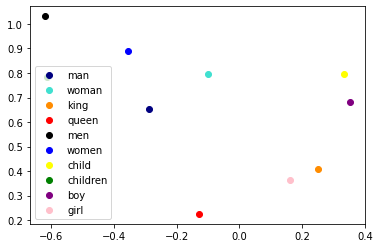

In [22]:
plot_pca(['man', 'woman', 'king', 'queen','men','women','child','children','boy','girl'])

*   Which relationships do you observe in the plot above?
*   What relationships did you expect? 
*   Are these relationships actually present in the plot? If not, why do you think they are not visible?



Another way to inspect word embeddings is to look at words that are closest to a specific target word. Closeness in a vector space can be calculated by using for example cosine similarity. In the function below, we calculate for a given word the top 10 closest words.

In [38]:
def find_closest_words(word):
  if word not in item_to_id:
    raise IOError('This item is not in the vocabulary')
    
  else:
    id_w = item_to_id[word]
    emb_w = emb_matrix[id_w]
    # normalize the embedding vector unit length
    norm_emb_w = emb_w / np.linalg.norm(emb_w)
    
    top_10 = {}
    
    # iterate over all words
    for idx in range(emb_matrix.shape[0]):
      # ignore the word itself
      if idx != id_w:
        
        # normalize to unit length
        norm_curr_w = emb_matrix[idx] / np.linalg.norm(emb_matrix[idx])
        
        # cosine similarity = dot product of normalized vectors
        cos_sim = np.dot(norm_emb_w, norm_curr_w)
        
        # keep list of top 10 largest cos similarities
        if len(top_10) >= 10:
          for sim in top_10.keys():
            if cos_sim > sim:
              
              del top_10[sim]
              top_10[cos_sim] = id_to_item[idx]
              break
        
        else:
          top_10[cos_sim] = id_to_item[idx]
          
        
    print('Words with largest cosine similarity w.r.t. {0}'.format(word))
    # sort the top 10 
    for sim in sorted(top_10, key=float, reverse=True):
      print('{0} ({1})'.format(top_10[sim], sim))
    print()  

The function above can be called as follows:

In [51]:
find_closest_words('man')
find_closest_words('help')

Words with largest cosine similarity w.r.t. man
driver (0.47241793572611984)
broker (0.45628229213634985)
guy (0.44758959671003606)
artist (0.44665546300353665)
boss (0.42255025799730783)
adjuster (0.4135849757130333)
physician (0.4028276171874261)
girl (0.4004175330602062)
investigator (0.3945723625036752)
plaintiff (0.3908913302968119)

Words with largest cosine similarity w.r.t. help
helped (0.4634820947673968)
helps (0.39315136802544)
electronically (0.3501644609431267)
tables (0.33874045328026975)
corner (0.3357360016911607)
trees (0.3345952103955207)
fundamentals (0.33331896411653095)
jets (0.32188015375107)
invariably (0.31756797554988214)
haunts (0.3131492047941045)



'haunts'

Notice that we did not optimize our embedding space to contain any relationships - this is merely a by-product of training a neural language model. 

*   Which relationships do you see between the target word and its closest words?
*   What kind of relationships do you see: syntactic and/or semantic?
*   Do all closest words have clear relationships with the target word?



## PERSONAL EXERCISE -- PREPARATION FOR THE EXAM

This sections contains a personalized variant on the exercise(s) above.   **You need to bring the printout of this COLAB exercise to the exam**, where it will be used to ask you some further personalized questions.

There are 3 cells in this section:

**[1]** This cell will generate your personal key for the exercise.  Enter your KULeuven ID and execute the cell.  
Don't modify the hidden parameters ! (you can play with them, but the exercise you bring to the exam should be based on the default settings)

**[2]** This cell contains the code for the exercise  
  + First your personal the wordlist is generated. It is a small selection (n=3) of the 2500 most frequent words in the training database that are closest (DTW distance) to your personal key.  
  + Then the find_closest_words() routine is used to find the nearest neighbours in embedding space for the words in your wordlist. *Bring the full output of this COLAB cell to the exam, including key, wordlist and nearest neighbours*. That is all you need bring.  For each of your personal words, give a motivation explanation which ones of the close neighbours in embedded space are plausible in your opionion.   

**[3]** (optional) In this cell you can plot via PCA the relationships of the words in your wordlist.  It is rather unlikely that you will see much here. 





In [34]:
import random, re
kul_id = 's0123456' #@param {type:"string"}
vocsize = 2500 
selection = 3 
length = 8 
ngram_length = 4 
# UTILITY: a random word generator made up of frequent letter ngrams
def random_word(length=10,seed='u012345',text='abcdefghjk',ng=5):
  chars = [text[i:i + ng] for i in range(0, len(text)-ng+1) if ' ' not in text[i:i+ng]]
  char_counter = collections.Counter(chars)
  ngrams= ([w for (w,n) in char_counter.most_common(100)])
  random.seed(seed,version=2)
  nwords = length//ng + 1
  ngram_word = "".join(random.sample(ngrams,nwords))
  return(ngram_word[0:length])
######### generate your personal key  #####################
text = train_file.decode(encoding='utf-8', errors='strict').lower().replace('\n',' ').replace('<unk>',' ').replace('$',' ')
my_key = random_word(length=length,seed=kul_id,text=text.replace(' ',''),ng=ngram_length)  
print("Generated Key: ", my_key)

Generated Key:  sionthen


In [37]:
### UTILITY:  dtw between character strings
def stringdtw(str1,str2):
  s1 = '#'+str1
  s2 = '#'+str2
  # initialize
  Dist = [i for i in range(0,len(s2)) ] 
  Dist[0] = 0
  for i in range(1,len(s1)):
    Dist1 = Dist.copy()
    Dist[0] = Dist1[0] + 1
    for j in range(1,len(s2)):
      Dist[j] =  min(
          Dist1[j-1] + int(s1[i]!=s2[j]) ,
          Dist1[j] + 1.2,
          Dist[j-1] + 1.2)
  return(Dist[len(s2)-1])
#############################################################################

######### generate your personal word list ################
wlist = most_frequent_words[0:vocsize]
dist = np.zeros(vocsize,dtype='float')
for i in range(vocsize):
  dist[i] = stringdtw(wlist[i],my_key)
sorted_wordlist = [wlist[i] for i in np.argsort(dist) if len(wlist[i]) >= length-2]
my_wordlist = sorted_wordlist[0:selection]
#[(w,stringdtw(w,my_key)) for w in my_wordlist]

######### find the closest words to your personal wordlist according to embeddings  ##############
print("="*70)
print("Your KULeuven ID:", kul_id)
print("Your Personal Key:",my_key)
print("Your Personal Wordlist: ", my_wordlist)
print("="*70)
for w in my_wordlist:
  _ = find_closest_words(w)

Your KULeuven ID: s0123456
Your Personal Key: sionthen
Your Personal Wordlist:  ['southern', 'monthly', 'stephen']
Words with largest cosine similarity w.r.t. southern
northern (0.5113382079896625)
miami-based (0.49354313475616834)
monsanto (0.4868956247933389)
neighboring (0.4583223853442856)
bristol-myers (0.44386833242118107)
ancient (0.4230242449013266)
privatized (0.41222188486370037)
direct-mail (0.39548024389430414)
col. (0.3904326307148351)
revise (0.37927486041459124)

Words with largest cosine similarity w.r.t. monthly
annual (0.440127589040307)
non-interest (0.4304677959678713)
year-to-year (0.4158621322477106)
chaotic (0.4024589289552134)
simultaneous (0.4012134022184989)
statutory (0.3827989438766738)
commanding (0.37910538432983076)
friday-the-13th (0.37395273099122117)
decisive (0.35154904558766054)
syrian (0.34830048072232545)

Words with largest cosine similarity w.r.t. stephen
pierre (0.7213169139963564)
ian (0.7026505523351174)
alvin (0.6888646792566868)
andrew (0.67

Words with largest cosine similarity w.r.t. southern
northern (0.5113382079896625)
miami-based (0.49354313475616834)
monsanto (0.4868956247933389)
neighboring (0.4583223853442856)
bristol-myers (0.44386833242118107)
ancient (0.4230242449013266)
privatized (0.41222188486370037)
direct-mail (0.39548024389430414)
col. (0.3904326307148351)
revise (0.37927486041459124)



AttributeError: ignored

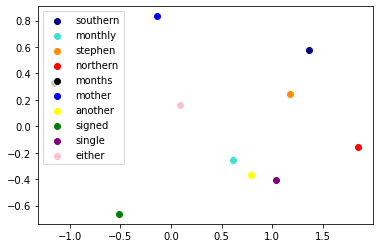

In [49]:
# You can look for similarities in your word list, but the words in this list don't have much in common, 
# so you probably won't see much, but you can trye
plot_pca(sorted_wordlist[0:10])
close_words = find_closest_words(sorted_wordlist[0])
#plot_pca(close_words)
close_words.type

Notice that not all words will have sensible nearest neighbours.  The main reason is that the words in your wordlist might have verry little in common
(this was not part of the selection criterion).  

More generally, the model is trained on a relatively small dataset. Not all words will have large enough frequency and the model is not optimized to encode these relationships.  Another anomaly due to the small training dataset is that quite unexpected neighbours pop up in the list. 



## Testing networks

Before going into the details of training a neural language model, we will first show how you can use a trained model. The output of the neural network is given to a **softmax** function, which converts the output values (also called logits) to values between 0 and 1. The sum of those values is 1, and thus the output of the softmax function can be treated as a probability distribution. 

We can then find the probability of a specific word  following the current input word by looking up its probability in the output vector of the softmax function. To find the most probable word, we look for the maximum probability. In practice, we usually work with **log probabilities**, because if we are computing the probability of a sequence of words, the multiplication of all probabilities easily becomes very small. Converting the probabilities to the log domain and summing them instead of multiplying alleviates this problem. The log probability of a sentence is then sum of the log probabilities of every word in the sentence, given their context.

Let's first train a network:

In [ ]:
# first make sure that we start training the model from scratch, by removing the models/ directory
!rm -rf baseline

# train the model
run_lm(name='baseline', train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path baseline/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 1422.8054634693256
9984
Validation perplexity: 1017.3037157941546
Epoch 2
49984
Train perplexity: 701.0023658342516
9984
Validatio

During training, not the log probabilities are printed but the **perplexity** of the model. Perplexity is commonly used to measure the quality of a language model, and corresponds to $$e^{\frac{1}{N}~ln~P(x_1~\ldots~x_N)}$$ You see that it is closely related to the log probability. The lower the perplexity, the better. Notice that in the example above the perplexities are quite high because we are training a small model on a small dataset.

To test the model we define a function that prints the log probability of a sentence. The sentence is converted to indices and then given to the model:

In [ ]:
def get_log_prob(test_sent):
  
  # convert words to indices
  test_idx = []
  for w in test_sent.split(' '):
    if w not in item_to_id:
      raise IOError("{0} is not part of the vocabulary".format(w))
    else:
      test_idx.append(item_to_id[w])

  # feed sentence to the model
  run_lm(name='baseline',
                test_ids=test_idx,
                test_log_prob=True)

To get the log probability of a specific sentence, use the following commands:

In [ ]:
get_log_prob(test_sent='this is a test <eos>')
get_log_prob(test_sent='test a a a <eos>')

INFO:tensorflow:Restoring parameters from baseline/rnn.ckpt
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path baseline/model.ckpt
INFO:tensorflow:Starting queue runners.
Log probability: -18.244898319244385
INFO:tensorflow:Restoring parameters from baseline/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path baseline/model.ckpt
INFO:tensorflow:Starting queue runners.
Log probability: -26.25789451599121




*   Which sentence has the largest probability? Is this what you expected?
*   What would happen if you compare the probability of two sentences with an unequal number of words? Remember that the probability of a sentence = product of the probabilities of each word = sum of the log probabilities of each word.



You can test your own sentences here:

In [ ]:
get_log_prob('good things happen to good people')
get_log_prob('bad things happen to bad people')

INFO:tensorflow:Restoring parameters from baseline/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path baseline/model.ckpt
INFO:tensorflow:Starting queue runners.
Log probability: -39.77164697647095
INFO:tensorflow:Restoring parameters from baseline/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path baseline/model.ckpt
INFO:tensorflow:Starting queue runners.
Log probability: -39.67345595359802


## Training networks

Training neural networks requires a lot of hyperparameter tuning. The hyperparameters of a neural network are for example the type of cell, its size, the method that is used for updating its parameters (also called 'optimizer' ), the type and strength of regularization, ... . All these hyperparameters have to be chosen before the network can built, trained and tested, and they all have to some extent an influence on the  performance of the model.

The default arguments for our network are the following:


* cell: 'LSTM'
* optimizer: 'Adam'
* lr: 0.01
* embedding_size: 64
* hidden_size: 128
* dropout_rate: 0.5

We will explain each of these arguments in the following sections.



### Type of cell

Recurrent neural networks are neural networks that take as input a combination of the standard input and the hidden state of the previous time step. The simplest form of recurrent neural network, often called **vanilla recurrent neural network**, looks like this (picture taken from the Chris Olah's [blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)):

![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

The green blocks in the picture represent the neural network. You see that the inputs to the neural network are the current input word $\mathbf{x}_t$ (this is the word embedding as discussed before) and the state of the previous time step $\mathbf{h}_{t-1}$. The network multiplies both inputs with weights and applies a non-linearity, in this case $\tanh$. 

The network that we trained in the previous section is not a vanilla recurrent neural network, but a **long short-term memory (LSTM)** network, which is a more powerful variant. If you're interested in knowing how the LSTM works, the blog post mentioned above is a great introduction.

For comparison, let's now train a simple RNN instead of an LSTM:

In [ ]:
run_lm(name='RNN', cell='RNN', train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path RNN/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 1705.7564808156153
9984
Validation perplexity: 1778.5944466786311
Epoch 2
49984
Train perplexity: 1172.738639919078
9984
Validation perplexity: 1755.676510620942
Epoch 3
49984
Train perplexity: 1972.0418057248721
9984
Validation perplexity: 1422.5110510650313
Epoch 4
49984
Train perplexity: 1285.2856863451182
9984
Validation perplexity: 2694.3795605490322
Epoch 5
49984
Train perplexity: 2552.6623814880745
9984
Validation perplexity: 2254.431186012179
Saved the model to  RNN/rnn.ckpt
Test perplexity: 1259.5610217295177


Notice that the simple RNN performs much worse than the LSTM (the perplexities are much higher).

*   How does the simple RNN compare with the LSTM that you trained in the previous section? Are the perplexities lower?
*   Look at the evolution of the train perplexities and compare it with the evolution of the validation perplexities. Does a lower train perplexity automatically correspond to a lower validation perplexity? If this is not the case, why do you think this happens?



### Optimizer

Another important hyperparameter for neural networks is the type of optimizer. Training a neural network implies that you give an input to the network, calculate the output and the difference with the expected output, which is equal to the **error** or **loss**. To update the parameters based on the error, the **gradient** of the loss with respect to the parameters is calculated. The gradient tells you in which direction you need to move to maximize the loss. In our case, we want to minimize the loss so we will move in the opposite direction (negative gradient). The optimizer then decides how this gradient is used to change the parameters. 

The simplest option is to subtract (a scaled version of) the gradient from the parameters. This optimizer is called **stochastic gradient descent**. In the experiments in the previous section, we used another, more complicated, optimizer called **Adam**.

Let's now train a network with stochastic gradient descent instead of Adam:

In [ ]:
run_lm(name='SGD', optimizer='SGD', train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path SGD/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 9163.415712532133
9984
Validation perplexity: 8165.583044600297
Epoch 2
49984
Train perplexity: 6161.551100530455
9984
Validation perplexity: 4057.4845087240874
Epoch 3
49984
Train perplexity: 2767.0928230268364
9984
Validation perplexity: 1995.2783000350964
Epoch 4
49984
Train perplexity: 1682.8862053722717
9984
Validation perplexity: 1490.3760541651302
Epoch 5
49984
Train perplexity: 1331.5028995145956
9984
Validation perplexity: 1252.1960311061996
Saved the model to  SGD/rnn.ckpt
Test perplexity: 1271.8579770288088




*   Are the perplexities better than the baseline model?

### Learning rate

Judging from the perplexities above, it seems like the Adam optimizer is the best choice for training our network. However, the interplay between the different hyperparameters of a neural network is complicated, and it is very well possible that a specific optimizer needs a different learning rate. 
Let's try SGD with a learning rate of 1 instead of the default 0.01:

In [ ]:
run_lm(name='SGD_1', optimizer='SGD', lr=1.0, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path SGD_1/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 2308.9353346379958
9984
Validation perplexity: 1328.0109578298136
Epoch 2
49984
Train perplexity: 1154.8752105959206
9984
Validation perplexity: 1040.068049832487
Epoch 3
49984
Train perplexity: 904.9152428161045
9984
Validation perplexity: 815.0615660308715
Epoch 4
49984
Train perplexity: 750.0470154423635
9984
Validation perplexity: 684.6410274070233
Epoch 5
49984
Train perplexity: 622.6372437265258
9984
Validation perplexity: 766.2130514445242
Saved the model to  SGD_1/rnn.ckpt
Test perplexity: 673.6252516319827




*   Does using a larger learning rate improve results for SGD?
*   Is this result better than for the model optimized with Adam?



Maybe using a larger learning rate helps in general? Let's try the same learning rate in combination with Adam:

In [ ]:
run_lm(name='Adam_1', lr=1.0, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path Adam_1/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 3.589548911517029e+36
9984
Validation perplexity: 9.942371571501244e+45
Epoch 2
49984
Train perplexity: 1.1031082078811483e+36
9984
Validation perplexity: 8.813929519825124e+33
Epoch 3
49984
Train perplexity: 3.168579945851953e+36
9984
Validation perplexity: 1.2172510883810984e+39
Epoch 4
49984
Train perplexity: 7.912157303853018e+38
9984
Validation perplexity: 4.196741229375931e+39
Epoch 5
49984
Train perplexity: 1.3074909916923593e+38
9984
Validation perplexity: 6.011041202144656e+37
Saved the model to  Adam_1/rnn.ckpt
Test perplexity: 3.2098538070973146e+37




*   Does using a larger learning rate for Adam work better?
*   What can you conclude about the interplay between optimizer and learning rate, based on these experiments?



Let's now reduce the learning rate for Adam, from 0.01 to 0.001:

In [ ]:
run_lm(name='Adam_0.001', lr=0.001, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path Adam_0.001/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 3146.5901947295274
9984
Validation perplexity: 935.275526079948
Epoch 2
49984
Train perplexity: 691.7595192557618
9984
Validation perplexity: 962.5625978252453
Epoch 3
49984
Train perplexity: 663.3642385539762
9984
Validation perplexity: 980.9729858977084
Epoch 4
49984
Train perplexity: 647.3405518895783
9984
Validation perplexity: 980.203111002569
Epoch 5
49984
Train perplexity: 680.9535433199497
9984
Validation perplexity: 966.6005212434247
Saved the model to  Adam_0.001/rnn.ckpt
Test perplexity: 821.71921440677




*   Is Adam with a learning rate of 0.001 better than with a learning rate of 0.01? 




### Size of the embedding

Let's now take a look at the influence of the size of the LSTM on its performance. By default, we train a model with embeddings of size 64 and a hidden layer of size 128. Let's see what happens if we reduce the size of the embedding:

In [ ]:
run_lm(name='emb16', embedding_size=16, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path emb16/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 1516.9057445634044
9984
Validation perplexity: 1019.4539297216154
Epoch 2
49984
Train perplexity: 714.18671150995
9984
Validation perplexity: 1129.8660099689662
Epoch 3
49984
Train perplexity: 601.6350880479511
9984
Validation perplexity: 1858.7379126202118
Epoch 4
49984
Train perplexity: 547.4979888085946
9984
Validation perplexity: 893.6314817441453
Epoch 5
49984
Train perplexity: 479.9246020826714
9984
Validation perplexity: 925.6698891137858
Saved the model to  emb16/rnn.ckpt
Test perplexity: 766.0131159113296




*   Is using a smaller embedding better or worse? Is there a large difference?



What about a larger embedding size?

In [ ]:
run_lm(name='emb128', embedding_size=128, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path emb128/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 1449.6313581314428
9984
Validation perplexity: 988.3753360020532
Epoch 2
49984
Train perplexity: 683.734065217858
9984
Validation perplexity: 1107.1456623215954
Epoch 3
49984
Train perplexity: 515.9514702025405
9984
Validation perplexity: 863.7947165975964
Epoch 4
49984
Train perplexity: 429.38329919492196
9984
Validation perplexity: 875.8815950574151
Epoch 5
49984
Train perplexity: 372.1902189092265
9984
Validation perplexity: 929.9011855919829
Saved the model to  emb128/rnn.ckpt
Test perplexity: 730.5247281881584


*   Is using a larger embedding better or worse? Is there a large difference?
*   The size of the vocabulary of our language model is 10.000, which is quite small. If we trained a language model with a larger vocabulary size (e.g. 100.000), what do you expect with respect to the relative differences between embedding sizes?

### Size of the hidden layer

We can also change the size of the hidden layer/the number of neurons in the network. In principle you also choose to increase the number of layers, but this is mainly useful for large datasets.

Let's first test a smaller hidden layer:

In [ ]:
run_lm(name='hidden64', hidden_size=64, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path hidden64/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 1610.5218115212474
9984
Validation perplexity: 1090.836945871033
Epoch 2
49984
Train perplexity: 734.4372322304617
9984
Validation perplexity: 951.8469317050921
Epoch 3
49984
Train perplexity: 598.4126421459439
9984
Validation perplexity: 905.1850925899746
Epoch 4
49984
Train perplexity: 496.03793163852464
9984
Validation perplexity: 882.8923036333134
Epoch 5
49984
Train perplexity: 431.9224959517401
9984
Validation perplexity: 877.6037038602651
Saved the model to  hidden64/rnn.ckpt
Test perplexity: 725.5993096810768


*   Is using a smaller hidden layer better or worse? Is there a large difference?



Let's now train a model with a larger hidden layer:

In [ ]:
run_lm(name='hidden256', hidden_size=256, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path hidden256/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
49984
Train perplexity: 1328.048444282265
9984
Validation perplexity: 897.6538676066048
Epoch 2
49984
Train perplexity: 634.2613010248848
9984
Validation perplexity: 1352.2876856423
Epoch 3
49984
Train perplexity: 554.4274875035626
9984
Validation perplexity: 912.1366322547909
Epoch 4
49984
Train perplexity: 463.10684909712865
9984
Validation perplexity: 863.7943651186979
Epoch 5
49984
Train perplexity: 397.954248042006
9984
Validation perplexity: 899.9768849358215
Saved the model to  hidden256/rnn.ckpt
Test perplexity: 716.3613317565005


*   Is using a smaller hidden layer better or worse? Is there a large difference?


Let's now train a baseline language model (with a hidden size of 128) on the full Penn TreeBank data set by using {train/valid/test}_ids_large:


In [ ]:
run_lm(name='large', train_ids=train_ids_large, valid_ids=valid_ids_large, test_ids=test_ids_large)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path large/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
929568
Train perplexity: 447.2116789156245
73760
Validation perplexity: 307.34181643509277
Epoch 2
929568
Train perplexity: 260.40191672554766
73760
Validation perplexity: 257.9523035858147
Epoch 3
929568
Train perplexity: 223.27730655017936
73760
Validation perplexity: 241.03046777546362
Epoch 4
929568
Train perplexity: 202.1095193608682
73760
Validation perplexity: 229.73737866213483
Epoch 5
929568
Train perplexity: 190.53770336703266
73760
Validation perplexity: 223.93702311332697
Saved the model to  large/rnn.ckpt
Test perplexity: 210.77565573353874




*   Can you directly compare the perplexity of this model with the perplexity of the model trained on the small dataset? Remember how perplexity is calculated. Are the validation and test sets the same for the small and large dataset?



Let's now train a model with a larger hidden size:

In [ ]:
run_lm(name='large_hidden256', hidden_size=256, 
              train_ids=train_ids_large, valid_ids=valid_ids_large, test_ids=test_ids_large)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path large_hidden256/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
929568
Train perplexity: 394.1867263447221
73760
Validation perplexity: 272.2507960801686
Epoch 2
929568
Train perplexity: 227.19213518106972
73760
Validation perplexity: 228.90276769465265
Epoch 3
929568
Train perplexity: 202.58496303748257
73760
Validation perplexity: 211.49774115623077
Epoch 4
929568
Train perplexity: 171.53407141555897
73760
Validation perplexity: 202.7777777579741
Epoch 5
929568
Train perplexity: 159.3700518405357
73760
Validation perplexity: 196.28063387788666
Saved the model to  large_hidden256/rnn.ckpt
Test perplexity: 185.93233378308892




*   Do you see improvement by using a larger hidden size?
*   Is this improvement relatively larger or smaller than the improvement you observed for the small data set?



### Try it yourself

Now try some different values for the hyperparameters that we discussed (cell, optimizer, lr, embedding_size, hidden_size):

In [ ]:
# run_lm(name='my_own_model', cell='LSTM', optimizer='Adam', lr='0.01', embedding_size='64', hidden_size='128', 
#        train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

The hyperparameters that we discussed here are only a small subset, there exist many more that can have an influence on the performance of the neural network. Another important class of hyperparameters is related to **regularization**. Since neural networks contain many parameters, they can easily start **overfitting**, which means that the network starts memorizing the training set and cannot generalize well to new data sets anymore. Two important methods are dropout (setting a proportion of the neurons to 0 during training) and early stopping (stop training if the performance on the validation set decreases), but there exist many more.



*   Have you seen examples of overfitting in the networks that we trained in this section? 


